# Analysis
Notebook that concentrates all the analysis done on the ExTRI2 resource and its validation

In [1]:
__import__('sys').path.append('../scripts/common/'); __import__('notebook_utils').table_of_contents('analysis.ipynb')

<h3>Table of contents</h3>


[Analysis](#Analysis)
- [Setup & configuration](#Setup-&-configuration)
- [2.2. Pipeline Results](#2.2.-Pipeline-Results)
- [3.3. Classifiers dataset improvement](#3.3.-Classifiers-dataset-improvement)
- [The ExTRI2 resource - OLD](#The-ExTRI2-resource---OLD)
  - [MUST CORRECT](#MUST-CORRECT)

## Setup & configuration

In [7]:
# IMPORTS
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import upsetplot
import warnings
from analysis import *


from Bio import Entrez
# *Always* tell NCBI who you are
Entrez.email = "example24@gmail.com"

## Custom functions
import sys

sys.path.append('../scripts/common/')
from notebook_utils import table_of_contents, table_from_dict, h3, h4, h5, md
from analysis import load_config, retrieve_annotations_entrez
pd.set_option('display.max_colwidth', 20)

In [2]:
# UNCOMMENT TO REIMPORT A CERTAIN FUNCTION AFTER MODIFYING ITS CODE
import importlib 
import analysis
importlib.reload(analysis)
from analysis import *

In [3]:
# LOAD & PREPROCESSING
config = load_config()

# Load ExTRI dataset
ExTRI2_df = pd.read_csv(config['final_ExTRI2_p'], sep="\t", dtype=str, keep_default_na=False)

# LOAD VALIDATION DATASET
# Load the validation dataset
validated_df           = pd.read_csv(config['final_validated_p'], sep='\t', header=0, dtype=str)


## 2.2. Pipeline Results

In [6]:
def split_in_dbTF_coTF_ll_coTF(ExTRI2_df):
    m_dbTF = ExTRI2_df['TF_type'].str.contains('dbTF')
    m_coTF = ExTRI2_df['TF_type'].apply(lambda x: 'coTF' in set(x.split(';'))) & ~m_dbTF
    m_ll_coTF = ExTRI2_df['TF_type'].str.contains('ll_coTF') & ~m_dbTF & ~m_coTF

    dbTF_df = ExTRI2_df[m_dbTF]
    coTF_df = ExTRI2_df[m_coTF]
    ll_coTF_df = ExTRI2_df[m_ll_coTF]

    return dbTF_df, coTF_df, ll_coTF_df    

dbTF_df, coTF_df, ll_coTF_df = split_in_dbTF_coTF_ll_coTF(ExTRI2_df)

In [7]:
# TABLES 1, 2
def table_1(ExTRI2_df, dbTF_df, coTF_df, ll_coTF_df) -> dict:

    h3("Table 1")

    analysis_dfs = []
    for df, name in [(ExTRI2_df, 'Total'), (dbTF_df, 'dbTF'), (coTF_df, 'coTF'), (ll_coTF_df, 'll_coTF')]:

        analytics = {}
        analytics['TRI-sentences'] = f"{len(df):,}"

        for mor in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            analytics[mor] = f"{len(df[df['MoR'] == mor]):,} ({len(df[df['MoR'] == mor])/len(df):.2%})"
        
        analytics['TG is not normalized'] = f"{(df['TG Id'].isna()).sum():,} ({(df['TG Id'].isna()).sum() / len(df):.2%})"
        analytics['TF is mutated'] = f"{(df['Mutated_TF'] == 'True').sum():,} ({(df['Mutated_TF'] == 'True').sum() / len(df):.2%})"
        analytics['Unique TRIs'] = f"{df['TRI Id'].nunique():,}"

        for T in ['TF', 'TG']:
            analytics[f'Unique {T} IDs'] = f"{df[f'{T} Id'].nunique():,}"
            analytics[f'Unique human {T} IDs'] = f"{df[df[f'{T} TaxID'] == '9606'][f'{T} Id'].nunique():,}"

        # Convert the analytics dictionary to a DataFrame and add it to the list
        analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=[name])
        analysis_dfs.append(analysis_df)

    display(pd.concat(analysis_dfs, axis=1))
    return 

def table_2(final_df, dbTF_df):

    # Obtained from other sources
    all_pmids = 38_776_000
    has_gene_entities = 6_507_211

    # Get the number of PMIDs in candidate sentences
    candidate_sents = pd.read_csv(config['raw_ExTRI2_p'], sep='\t', header=1, chunksize=1_000_000, keep_default_na=False)
    candidate_PMIDs = set()
    for chunk in candidate_sents:
        PMIDs = chunk['#SentenceID'].apply(lambda row: row.split(':')[1])
        candidate_PMIDs.update(PMIDs)

    has_TRIs = final_df['PMID'].nunique()
    has_dbTF_TRIs = dbTF_df['PMID'].nunique()

    h3("Table 2")
    analytics = {}
    analytics['All PMIDs'] = f"{all_pmids:,}"
    analytics['Has gene entities'] = f"{has_gene_entities:,} ({has_gene_entities / all_pmids:.2%})"
    analytics['Has candidate sentences'] = f"{len(candidate_PMIDs):,} ({len(candidate_PMIDs) / all_pmids:.2%})"
    analytics['Has TRIs'] = f"{has_TRIs:,} ({has_TRIs / all_pmids:.2%})"
    analytics['Has dbTF TRIs'] = f"{has_dbTF_TRIs:,} ({has_dbTF_TRIs / all_pmids:.2%})"


    analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=['Num sentences'])
    # analysis_df.to_excel('tables_figs/table_1.xlsx')
    display(analysis_df)

    return 

table_1(ExTRI2_df, dbTF_df, coTF_df, ll_coTF_df)
table_2(ExTRI2_df, dbTF_df)

<h3>Table 1</h3>

KeyboardInterrupt: 

<h3>Figure 2</h3>

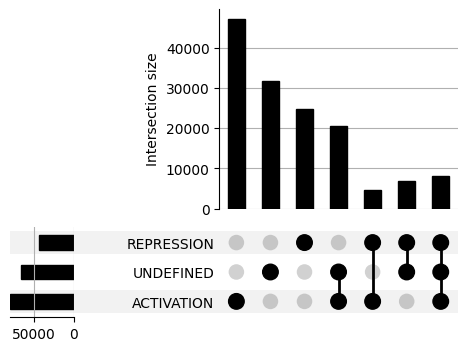

<h3>Table S6</h3>

,Counts
ACTIVATION,"47,148 (32.82%)"
REPRESSION,"24,763 (17.24%)"
UNDEFINED,"31,691 (22.06%)"
"ACTIVATION,REPRESSION","4,613 (3.21%)"
"ACTIVATION,UNDEFINED","20,593 (14.34%)"
"REPRESSION,UNDEFINED","6,735 (4.69%)"
"ACTIVATION,REPRESSION,UNDEFINED","8,108 (5.64%)"
1 MoR,"103,602 (72.12%)"
2 MoR,"31,941 (22.24%)"
3 MoR,"8,108 (5.64%)"


In [ ]:
# FIGURE 2 & TABLE S6
def figure_2(df):
    # 1. Get the sets of TRIs for each MoR

    # Create a set of TRIs for each MoR
    A_set = set(df[df["MoR"] == 'ACTIVATION']['TRI Id'])
    R_set = set(df[df["MoR"] == 'REPRESSION']['TRI Id'])
    U_set = set(df[df["MoR"] == 'UNDEFINED']['TRI Id'])
    # 2. Get the union of these sets
    MoR_listoflists = [
        ['ACTIVATION'], ['REPRESSION'], ['UNDEFINED'],
        ['ACTIVATION', 'REPRESSION'],
        ['ACTIVATION', 'UNDEFINED'],
        ['REPRESSION', 'UNDEFINED'],
        ['ACTIVATION', 'REPRESSION', 'UNDEFINED']
    ]
    MoR_counts = [
        len(A_set - R_set - U_set), 
        len(R_set - A_set - U_set), 
        len(U_set - R_set - A_set),
        len((A_set & R_set) - U_set),
        len((A_set & U_set) - R_set),
        len((U_set & R_set) - A_set),
        len(A_set & R_set & U_set),    
    ]

    # Ignore warnings for upsetplot: it has a lot (library seems like is not updated)
    warnings.filterwarnings('ignore')
    example = upsetplot.from_memberships(MoR_listoflists, data=MoR_counts)
    upsetplot.plot(example)  # doctest: +SKIP
    h3("Figure 2")
    # plt.title("")
    plt.show()
    warnings.filterwarnings('default')

    return MoR_counts, MoR_listoflists

def table_S6(MoR_counts, MoR_listoflists):
    h3("Table S6")
    MoR_counts_table = {}
    for label, count in zip(MoR_listoflists, MoR_counts):
        MoR_counts_table[",".join(label)] = count

    MoR_counts_table['1 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']])
    MoR_counts_table['2 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION,REPRESSION', 'ACTIVATION,UNDEFINED', 'REPRESSION,UNDEFINED']])
    MoR_counts_table['3 MoR'] = MoR_counts_table['ACTIVATION,REPRESSION,UNDEFINED']
    TOTAL = sum([MoR_counts_table[f'{n} MoR'] for n in range(1, 4)])

    for key, value in MoR_counts_table.items():
        MoR_counts_table[key] = f"{value:,} ({value / TOTAL:.2%})"

    display(pd.DataFrame.from_dict(MoR_counts_table, orient='index', columns=['Counts']))

MoR_counts, MoR_listoflists = figure_2(dbTF_df)
table_S6(MoR_counts, MoR_listoflists)

24402 (0.03) sentences are discarded as their TF/TG is mapped to +1 ID
There are 85 human genes in ExTRI2 that are not found in the all_human_genes df.
They appear in 406 rows, which will be discarded


Number of genes retrieved by category, considering direct human, and mouse/rat orthologs

,human,orthologs,unique,orth.unique,% uniq.,% orth.uniq.
Total,283636,429303,10100,14248,5.3%,10.7%
PROTEIN_CODING,273892,371481,9108,9902,44.2%,48.1%
ncRNA,8108,9975,814,820,3.7%,3.7%
PSEUDO,816,875,107,117,0.6%,0.7%
OTHER,700,610,36,31,4.3%,3.7%
snoRNA,21,25,11,13,0.9%,1.1%
tRNA,43,43,8,8,1.2%,1.2%
snRNA,31,31,7,7,4.2%,4.2%
BIOLOGICAL_REGION,14,0,6,0,0.0%,0.0%
rRNA,1,1,1,1,0.1%,0.1%


<span style='color:red'>There are 3 dbTFs that are non protein-coding. Should we remove them??</span>

,NCBI GeneID,Symbol,Gene Type,Taxonomic Name,Description
8461,100859930,HEIH,ncRNA,Homo sapiens,hepatocellular c...
11907,100288711,DUX4L9,PSEUDO,Homo sapiens,double homeobox ...
17113,58160,NFE4,ncRNA,Homo sapiens,"nuclear factor, ..."


Number of retrieved human dbTFs

,unique,%
all considered,1839,100.0%
human,1271,69.1%
orthologs,1683,91.5%


<h3>Figure 3</h3>

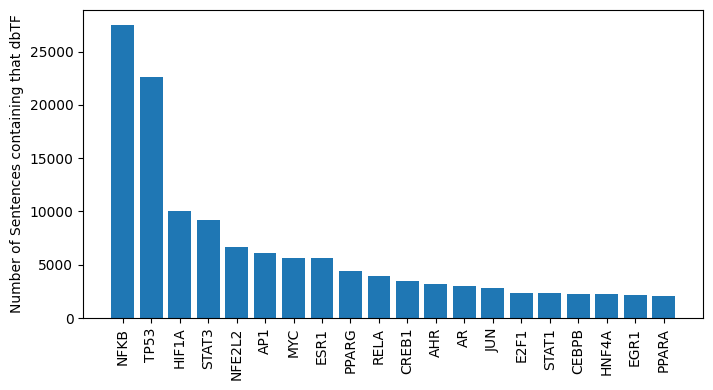

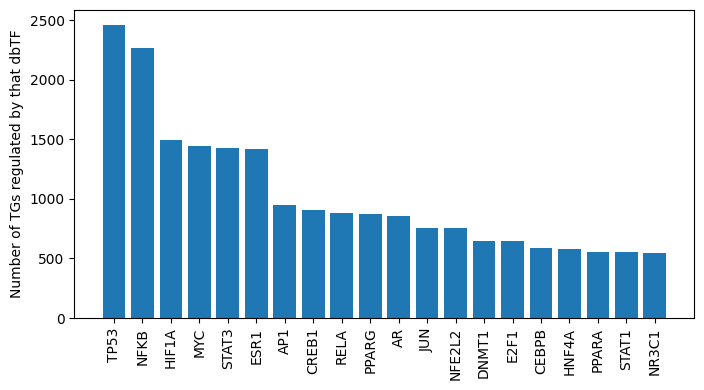

In [ ]:

def load_all_human_genes():
    # Load all human TGs
    # downloaded from: https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/9606/
    all_human_genes = pd.read_csv(config['all_human_TGs_p'], sep='\t', header=0, dtype=str)
    all_human_genes = all_human_genes[['NCBI GeneID', 'Symbol', 'Gene Type', 'Taxonomic Name', 'Description']]
    all_human_genes.loc[all_human_genes['Gene Type'].isna(), 'Gene Type'] = 'nan'

    # Add AP1 and NFKB complexes
    all_human_genes = pd.concat([all_human_genes, pd.DataFrame({
        'NCBI GeneID': ['Complex:AP1', 'Complex:NFKB'], 
        'Symbol': ['AP1', 'NFKB'],
        'Description': ['', ''],
        'Taxonomic Name': ['Homo sapiens', 'Homo sapiens'],
        'Gene Type': ['PROTEIN_CODING', 'PROTEIN_CODING'],
        })], ignore_index=True)
    
    # Ensure the data is expected: all human, no duplicate IDs
    assert all_human_genes['Taxonomic Name'].nunique() == 1
    assert all_human_genes['Taxonomic Name'].unique()[0] == 'Homo sapiens'
    assert (all_human_genes['NCBI GeneID'].duplicated()).sum() == 0 

    return all_human_genes

def display_TG_distribution(human_dbTF_df: pd.DataFrame, dbTF_df: pd.DataFrame, all_human_genes: pd.DataFrame) -> None:
    '''Display how many TGs we have retrieved'''

    # Initialise dict    
    TG_types = {}
    TG_types['Total'] = {
        'human': len(human_dbTF_df),
        'orthologs': len(dbTF_df),
        'unique': len(human_dbTF_df['TG Id'].unique()),
        'orth.unique': len(dbTF_df['TG_human_entrez_gene'].unique()),
        '% uniq.': f"{len(human_dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}",
        '% orth.uniq.': f"{len(dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}"
    }

    # Fill in dict
    for gene_type in all_human_genes['Gene Type'].unique():
        human_genes_of_gene_type = all_human_genes[all_human_genes['Gene Type'] == gene_type]['NCBI GeneID']

        human_sents = human_dbTF_df[human_dbTF_df['TG Id'].isin(human_genes_of_gene_type)]
        ortholog_sents = dbTF_df[dbTF_df['TG_human_entrez_gene'].isin(human_genes_of_gene_type)]
        TG_types[gene_type] = {
            'human': len(human_sents),
            'orthologs': len(ortholog_sents),
            'unique': len(human_sents['TG Id'].unique()),
            'orth.unique': len(ortholog_sents['TG_human_entrez_gene'].unique()),
        }
        TG_types[gene_type]['% uniq.']      = f"{TG_types[gene_type]['unique'] / len(human_genes_of_gene_type):.1%}"
        TG_types[gene_type]['% orth.uniq.'] = f"{TG_types[gene_type]['orth.unique'] / len(human_genes_of_gene_type):.1%}"


    # Convert to dataframe & display
    md("Number of genes retrieved by category, considering direct human, and mouse/rat orthologs")
    display(pd.DataFrame.from_dict(TG_types, orient='index').sort_values(by='unique', ascending=False))

def display_TF_distribution(human_dbTF_df, dbTF_df, all_human_genes, ):

    # Check if all dbTFs are protein-coding
    retrieved_TF_IDs = set(human_dbTF_df['TF Id'])
    assert retrieved_TF_IDs - set(all_human_genes['NCBI GeneID']) == set(), "Some dbTFs are not part of the NCBI df"

    # TODO - Fix. Makes no sense non-protein-coding genes can be TFs. 
    #       1. Check where do they come from. TFCheckpoint? (I have to check this anyways)
    #       2. Ask Astrid whether we should remove them
    md("<span style='color:red'>There are 3 dbTFs that are non protein-coding. Should we remove them??</span>")
    non_protein_coding_dbTFs = retrieved_TF_IDs - set(all_human_genes[all_human_genes['Gene Type'] == 'PROTEIN_CODING']['NCBI GeneID'])
    display(all_human_genes[all_human_genes['NCBI GeneID'].isin(non_protein_coding_dbTFs)])

    # Get set of human dbTFs
    with open(config['dbTFs_p'], 'r') as f:
        dbTFs_set = {l.strip('\n') for l in f}
    human_dbTFs_set = dbTFs_set.intersection(set(all_human_genes['NCBI GeneID'])) 

    dbTF_retrieval_t = {
        'all considered': len(human_dbTFs_set),
        'human': len(human_dbTF_df['TF Id'].unique()),
        'orthologs': len(dbTF_df['TF_human_entrez_gene'].unique())
    }
    for k, v in dbTF_retrieval_t.items():
        dbTF_retrieval_t[k] = {
            "unique": v,
            "%": f"{v / len(human_dbTFs_set):.1%}"
        }


    md("Number of retrieved human dbTFs")
    display(pd.DataFrame.from_dict(dbTF_retrieval_t, orient='index'))

def figure_3(human_dbTF_df):
    '''Plot the most common dbTFs'''

    h3("Figure 3")

    # Plot the most common dbTFs
    def plot_counts(df, ylabel):
        counts = df['TF Symbol'].value_counts()
        plt.figure(figsize=(8,4))
        plt.bar(counts[:20].index, counts[:20])
        plt.xticks(rotation='vertical')
        plt.ylabel(ylabel)

    plot_counts(human_dbTF_df, "Number of Sentences containing that dbTF")
    unique_TRIs = human_dbTF_df.drop_duplicates(subset='TRI Id', keep='first')
    plot_counts(unique_TRIs, "Number of TGs regulated by that dbTF")
    plt.show()    


def human_TF_TG_analysis(ExTRI2_df):
    '''Check the category of the found TGs'''

    # Load dataframe of all human genes
    all_human_genes = load_all_human_genes()

    # Show how many sentences have multiple mappings
    multiple_mapped = ((ExTRI2_df['TF Id'].str.contains(';')) | (ExTRI2_df['TG Id'].str.contains(';'))).sum()
    print(f"{multiple_mapped} ({multiple_mapped / len(ExTRI2_df):.2f}) sentences are discarded as their TF/TG is mapped to +1 ID")

    # Filter ExTRI2 by only those containing human dbTFs (ignore those mapped to +1 ids)
    dbTF_df = ExTRI2_df[ExTRI2_df['TF_type'] == 'dbTF']
    human_dbTF_df = dbTF_df[(dbTF_df['TG TaxID'] == '9606') & (dbTF_df['TF TaxID'] == '9606')] 

    # Discard human TGs that are not found in the NCBI human genes df
    # TODO - Ask Astrid if she thinks this is a good approach. Should we remove from the ExTRI2_df too? If so, I should also do mouse & rat
    m_TG_id = human_dbTF_df['TG Id'].isin(all_human_genes['NCBI GeneID'])
    print(f"There are {len(human_dbTF_df[~m_TG_id]['TG Id'].unique())} human genes in ExTRI2 that are not found in the all_human_genes df.")
    print(f"They appear in {(~m_TG_id).sum()} rows, which will be discarded")
    human_dbTF_df = human_dbTF_df[m_TG_id]

    # Show how many TGs we've obtained
    display_TG_distribution(human_dbTF_df, dbTF_df, all_human_genes)

    # Show how many TFs we've obtained
    display_TF_distribution(human_dbTF_df, dbTF_df, all_human_genes)

    # Plot counts
    figure_3(human_dbTF_df)

    return

human_TF_TG_analysis(ExTRI2_df)

## 3.3. Classifiers dataset improvement
See `scripts/classifiers_training/prepare_reannotation_Excels.ipynb` for the figures

## The ExTRI2 resource - OLD

In [ ]:
# TODO - Remove if it is useless for the article

In [ ]:
def get_analytics(df) -> dict:
    h3("General analytics")
    analytics = {}
    analytics['Num sents']      = len(df)
    analytics['Uniq sent-TRI Id'] = set(df['PMID+Sent+TRI_Id'])
    analytics['Uniq sent-TRI']  = set(df['PMID+Sent+TRI'])
    analytics['Uniq PMIDs']     = set(df['PMID'])
    analytics['Uniq TRI Id']    = set(df['TRI Id'])
    
    analytics['Uniq TF Id']     = set(df['TF Id'])
    analytics['Human TF Id']    = set(df[df['TF TaxID'] == '9606']['TF Id'])
    analytics['Human TF Id 2']  = set(df[df['TF TaxID'].str.contains('9606')]['TF Id'])

    analytics['Uniq TG Id']     = set(df['TG Id'])
    analytics['Human TG Id']    = set(df[df['TG TaxID'] == '9606']['TG Id'])
    analytics['Human TG Id 2']  = set(df[df['TG TaxID'].str.contains('9606')]['TG Id'])

    analytics['Num mutated TF']   = (df['Mutated_TF'] == 'True').sum()

    return analytics

def print_analytics(analytics):
    for key, value in analytics.items():
        if type(value) is set:
            num = len(value)
        else:
            num = value
        print(f"{key:<17}{num:,}")

print_analytics(get_analytics(ExTRI2_df))

<h3>General analytics</h3>

Num sents        836,024
Uniq sent-TRI Id 836,024
Uniq sent-TRI    834,723
Uniq PMIDs       293,108
Uniq TRI Id      284,724
Uniq TF Id       7,180
Human TF Id      2,758
Human TF Id 2    3,477
Uniq TG Id       25,805
Human TG Id      12,372
Human TG Id 2    13,591
Num mutated TF   2,755


In [ ]:
def show_analytics(label, num, total):
    total_len = total if type(total) is int else len(total)
    num_len = num if type(num) in (int, np.int64) else len(num)
    print(f'{label:30}{num_len:,}/{total_len:<10,}{num_len/total_len:>10.2%}')

def display_uniques():
    h3("Unique values")
    m_cols = ['#SentenceID', 'Sentence', 'PMID', 'TRI Id', 'PMID+Sent', 'PMID+Sent+TRI', 'PMID+Sent+TRI_Id', '',
            'Valid', 'MoR', 'TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol', 
            'Mutated Genes', 'Mutated_TF']

    total = len(ExTRI2_df)
    for col in m_cols:
        if col == '':
            print()
            continue
        num = ExTRI2_df[col].unique()
        show_analytics(f'Unique {col}', num, total)

def display_NA_values():
    h3("Columns with Na values")
    cols_to_ignore = ['Mutated Genes', 'Mutation offsets', 'tags']

    total = len(ExTRI2_df)
    for col in ExTRI2_df.columns:
        col_has_na = int(ExTRI2_df[col].isna().sum())
        if col_has_na & (col not in cols_to_ignore):
            show_analytics(f'{col}', col_has_na, total)

def display_cols_with_colons():
    h3("Columns with colons (;)")
    colon_cols = ['TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol', 
            'Mutated Genes']

    total = len(ExTRI2_df)
    for col in colon_cols:
        if col == '':
            print()
            continue
        num = int(ExTRI2_df[col].str.contains(';').sum())
        show_analytics(f'{col}', num, total)


    h3("Number of unique rows with ;")
    for col in colon_cols:
        if col == '':
            print()
            continue
        if ExTRI2_df[col].isna().sum() != 0:
            continue
        m = ExTRI2_df[col].str.contains(';')
        num = ExTRI2_df[m][col].unique()
        num_un = ExTRI2_df[col].unique()
        show_analytics(f'{col}', num, num_un)

def display_TF_types():
    h3("Joined TF Types")
    squished = ExTRI2_df['TF_type'].apply(lambda x: ";".join(set(x.split(';'))))
    print(squished.value_counts())
    print()

def display_unique_content_per_col():
    h3("Columns with <30 unique values")
    for col in ExTRI2_df.columns:
        uniq = ExTRI2_df[col].unique()
        if len(uniq) < 30:
            print(f"{col:25}{len(uniq):<10}{', '.join(uniq.astype(str))}")
        # else:
        #     print(f"{col:25}{len(uniq):<10}{', '.join(uniq[:2])}")


# TODO - Understand why there are Na values in hgnc & entrez_gene columns

display_uniques()
display_NA_values()
display_cols_with_colons()
display_TF_types()
display_unique_content_per_col()

<h3>Unique values</h3>

Unique #SentenceID            836,024/836,024      100.00%
Unique Sentence               834,786/836,024       99.85%
Unique PMID                   293,108/836,024       35.06%
Unique TRI Id                 284,724/836,024       34.06%
Unique PMID+Sent              539,924/836,024       64.58%
Unique PMID+Sent+TRI          834,723/836,024       99.84%
Unique PMID+Sent+TRI_Id       836,024/836,024      100.00%

Unique Valid                  1/836,024        0.00%
Unique MoR                    3/836,024        0.00%
Unique TF_type                78/836,024        0.01%
Unique TF TaxID               20/836,024        0.00%
Unique TG TaxID               22/836,024        0.00%

Unique TF                     24,083/836,024        2.88%
Unique TF Id                  7,180/836,024        0.86%
Unique TF Symbol              6,139/836,024        0.73%
Unique TF_human_entrez_gene   4,792/836,024        0.57%
Unique TF_hgnc_id             4,789/836,024        0.57%
Unique TF_human_symbol        4

<h3>Columns with Na values</h3>

<h3>Columns with colons (;)</h3>

TF_type                       16,562/836,024        1.98%
TF TaxID                      16,562/836,024        1.98%
TG TaxID                      8,131/836,024        0.97%

TF                            68/836,024        0.01%
TF Id                         16,562/836,024        1.98%
TF Symbol                     16,562/836,024        1.98%
TF_human_entrez_gene          105,310/836,024       12.60%
TF_hgnc_id                    105,257/836,024       12.59%
TF_human_symbol               105,257/836,024       12.59%

TG                            8/836,024        0.00%
TG Id                         8,131/836,024        0.97%
TG Symbol                     8,131/836,024        0.97%
TG_human_entrez_gene          87,741/836,024       10.50%
TG_hgnc_id                    87,705/836,024       10.49%
TG_human_symbol               87,705/836,024       10.49%
Mutated Genes                 1,760/836,024        0.21%


<h3>Number of unique rows with ;</h3>

TF_type                       75/78            96.15%
TF TaxID                      17/20            85.00%
TG TaxID                      19/22            86.36%

TF                            42/24,083         0.17%
TF Id                         1,200/7,180         16.71%
TF Symbol                     1,141/6,139         18.59%
TF_human_entrez_gene          1,924/4,792         40.15%
TF_hgnc_id                    1,921/4,789         40.11%
TF_human_symbol               1,921/4,789         40.11%

TG                            8/55,571         0.01%
TG Id                         1,965/25,805         7.61%
TG Symbol                     1,902/22,904         8.30%
TG_human_entrez_gene          4,636/17,525        26.45%
TG_hgnc_id                    4,631/17,521        26.43%
TG_human_symbol               4,631/17,522        26.43%
Mutated Genes                 778/2,005         38.80%


<h3>Joined TF Types</h3>

TF_type
dbTF            432325
ll_coTF         216298
coTF            184766
-;ll_coTF         1077
-;coTF             731
coTF;dbTF          547
-;dbTF             254
-;coTF;dbTF         13
ll_coTF;dbTF         7
ll_coTF;coTF         6
Name: count, dtype: int64



<h3>Columns with <30 unique values</h3>

Valid                    1         Valid
MoR                      3         UNDEFINED, ACTIVATION, REPRESSION
Mutated_TF               2         False, True
TF TaxID                 20        9606, 10090, 10116, 9606;9606, 10090;10090, 9606;9606;9606, 10116;10116, 9606;9606;9606;9606, 10090;10090;10090, 10116;10116;10116, 9606;9606;9606;9606;9606;9606, 10090;10090;10090;10090, 10116;10116;10116;10116, 9606;9606;9606;9606;9606;9606;9606;9606, 9606;9606;9606;9606;9606, 10090;10090;10090;10090;10090;10090;10090, 10090;10090;10090;10090;10090;10090, 10090;10090;10090;10090;10090, 9606;9606;9606;9606;9606;9606;9606, 9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606
TG TaxID                 22        9606, 9606;9606, 10090, 10116, 10090;10090, 9606;9606;9606, 10116;10116;10116, 10116;10116, 10090;10090;10090, 9606;9606;9606;9606, 10090;10090;10090;10090;10090, 9606;9606;9606;9606;9606;9606, 10090;10090;10090;10090, 10116;10116;10116;10116, 9606;9606;9606;9606;96

In [ ]:
analysis = {
    'TOTAL': [],
    'UNDEFINED': [],
    'ACTIVATION': [],
    'REPRESSION': [],
    'Uniq. TRIs': [],
    'TRI maps to 1 MoR': [],
    'TRI maps to 2 MoR': [],
    'TRI maps to 3 MoR': []
}
mask = ExTRI2_df['Mutated_TF'] == 'True'
TRI_mutated    = ExTRI2_df[mask]
TRI_nonmutated = ExTRI2_df[~mask]
for df in (ExTRI2_df, TRI_nonmutated, TRI_mutated):
    analysis['TOTAL'].append(len(df))
    for mor in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
        analysis[mor].append(f"{len(df[df['MoR'] == mor])} ({len(df[df['MoR'] == mor])/len(df):.2%})")
    analysis['Uniq. TRIs'].append(df['TRI Id'].nunique())

    # Analyse whether TRIs get assigned more than 1 MoR.
    grouped = df.groupby('TRI Id')['MoR'].nunique()
    analysis['TRI maps to 1 MoR'].append((grouped == 1).sum())
    analysis['TRI maps to 2 MoR'].append((grouped == 2).sum())
    analysis['TRI maps to 3 MoR'].append((grouped == 3).sum())
    
    
analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=['All ExTRI2_df', 'Non-mutated', 'Mutated'])
# display(analysis_df.style.format('{:,}'))
display(analysis_df)

,All ExTRI2_df,Non-mutated,Mutated
TOTAL,836024,833269,2755
UNDEFINED,244032 (29.19%),243211 (29.19%),821 (29.80%)
ACTIVATION,416370 (49.80%),415075 (49.81%),1295 (47.01%)
REPRESSION,175622 (21.01%),174983 (21.00%),639 (23.19%)
Uniq. TRIs,284724,284134,2031
TRI maps to 1 MoR,209430,209078,1825
TRI maps to 2 MoR,58825,58688,178
TRI maps to 3 MoR,16469,16368,28


In [ ]:
# TODO - Investigations to do:
# How many rows w/ +1 value? How to solve?
# NTNU - Something with that??

##  3.4. Validation Criteria and Process

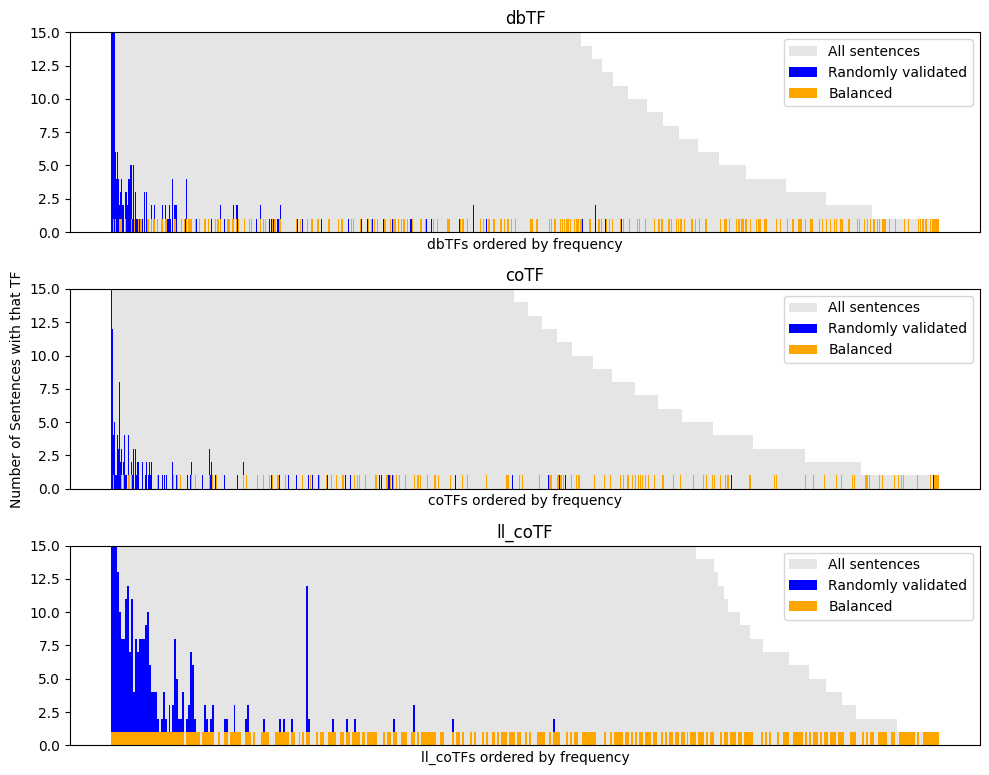

In [4]:
# PLOT - Ensure correctly balanced validation dataset
def plot_tf_validation_distribution(ax, tf_type: str, all_sents: pd.DataFrame, val_random: pd.DataFrame, val_balanced: pd.DataFrame, ylim=30):
    for df, label, color, alpha in [
        (all_sents, "All sentences", "grey", 0.2),
        (val_random, "Randomly validated", "blue", 1),
        (val_balanced, 'Balanced', "orange", 1)
    ]:
        counts = df['TF Id'].value_counts()
        ax.bar(counts.index, counts, label=label, color=color, alpha=alpha, width=1)
    ax.set_title(tf_type)
    ax.set_xticks([])
    #plt.xticks(rotation='vertical')
    ax.set_xlabel(f"{tf_type}s ordered by frequency")
    ax.set_ylim((0,ylim))
    ax.legend()

def plot_all_tf_validation_distributions(title, ExTRI2_df, validated_1mapping, figsize=(15, 10), ylim=30):

    fig, axes = plt.subplots(3, 1, figsize=figsize)
    for i, TF_type in enumerate(['dbTF', 'coTF', 'll_coTF']):
        TRI_subset = ExTRI2_df[ExTRI2_df['TF_type'] == TF_type]
        validated_subset = validated_1mapping[(validated_1mapping['TF_type_validated'] == TF_type)]

        validated_subset_b = validated_subset[validated_subset['method'] == 'balanced']
        validated_subset_r = validated_subset[validated_subset['method'] == 'random']

        plot_tf_validation_distribution(axes[i], TF_type, TRI_subset, val_balanced = validated_subset_b, val_random = validated_subset_r, ylim=ylim)
    axes[1].set_ylabel(f"Number of Sentences with that TF")



    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

title = "Distribution of the TFs for the random and balanced datasets for the three TF types"
plot_all_tf_validation_distributions('', ExTRI2_df, validated_df[(validated_df['pre-post'] == 'pre') & (validated_df['Label'] == 'TRUE')], figsize=(10, 8), ylim = 15)

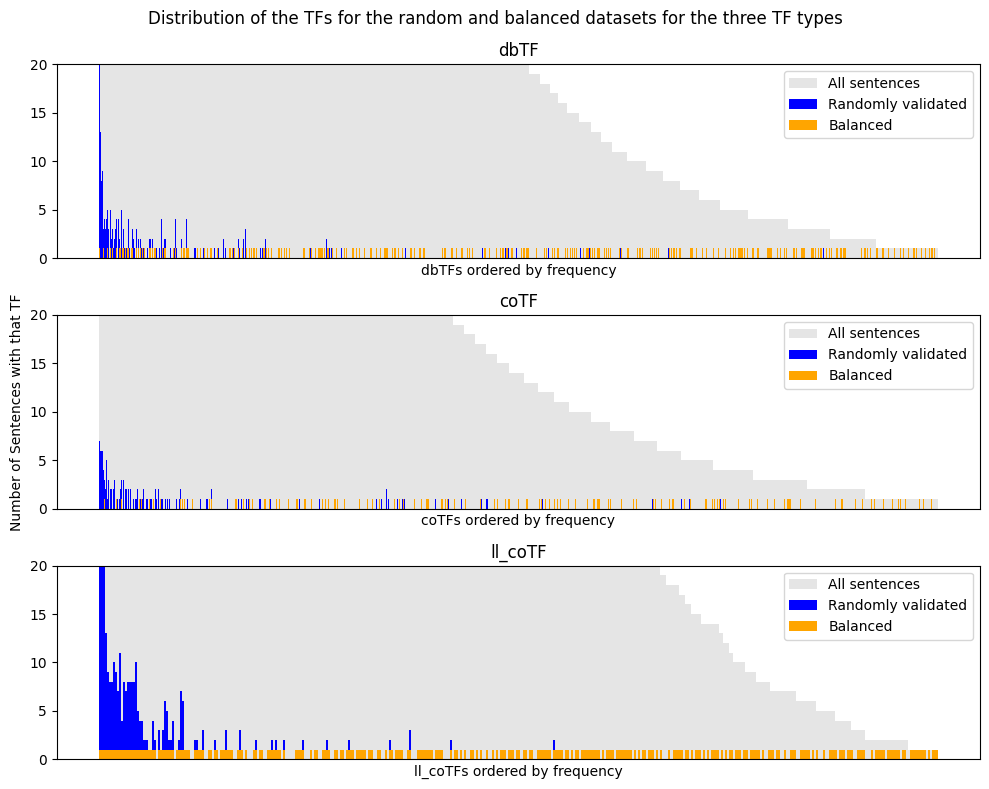

In [5]:
plot_all_tf_validation_distributions(title, ExTRI2_df, validated_df[(validated_df['pre-post'] == 'post') & (validated_df['Label'] == 'TRUE')], figsize=(10, 8), ylim = 20)

<h3>Other issues</h3>

Other issues
mutation      796
PPI           370
Splitter       52
negation       38
suboptimal      6
Name: count, dtype: int64

52/3981 sentences are incorrecty splitted
6/3981 sentences are suboptimal


num_sents  mutation       PPI  negation
tf_type Valid? method   pre-post                                        
coTF    F      balanced post           152  0.026316  0.565789  0.006579
                        pre            187  0.032086  0.518717  0.000000
               random   post           159  0.062893  0.628931  0.006289
                        pre            195  0.051282  0.528205  0.005128
        T      balanced post           277  0.400722  0.000000  0.010830
                        pre            257  0.428016  0.000000  0.007782
               random   post           303  0.458746  0.000000  0.006601
                        pre            313  0.460064  0.000000  0.006390
dbTF    F      balanced post           134  0.037313  0.268657  0.014925
                        pre            164  0.060976  0.207317  0.006098
               random   post           128  0.187500  0.054688  0.023438
                        pre            142  0.183099  0.063380  0.021127
        T      balanced post           725  0.217931  0.000000  0.008276
                        pre            705  0.245390  0.000000  0.011348
               random   post           759  0.310935  0.000000  0.015810
                        pre            764  0.311518  0.000000  0.015707
ll_coTF F      balanced post           121  0.008264  0.471074  0.008264
                        pre            120  0.008333  0.391667  0.000000
               random   post           163  0.018405  0.441718  0.000000
                        pre            198  0.015152  0.373737  0.000000
        T      balanced post           164  0.274390  0.000000  0.012195
                        pre            150  0.306667  0.000000  0.013333
               random   post           233  0.317597  0.000000  0.021459
                        pre            237  0.320675  0.000000  0.021097

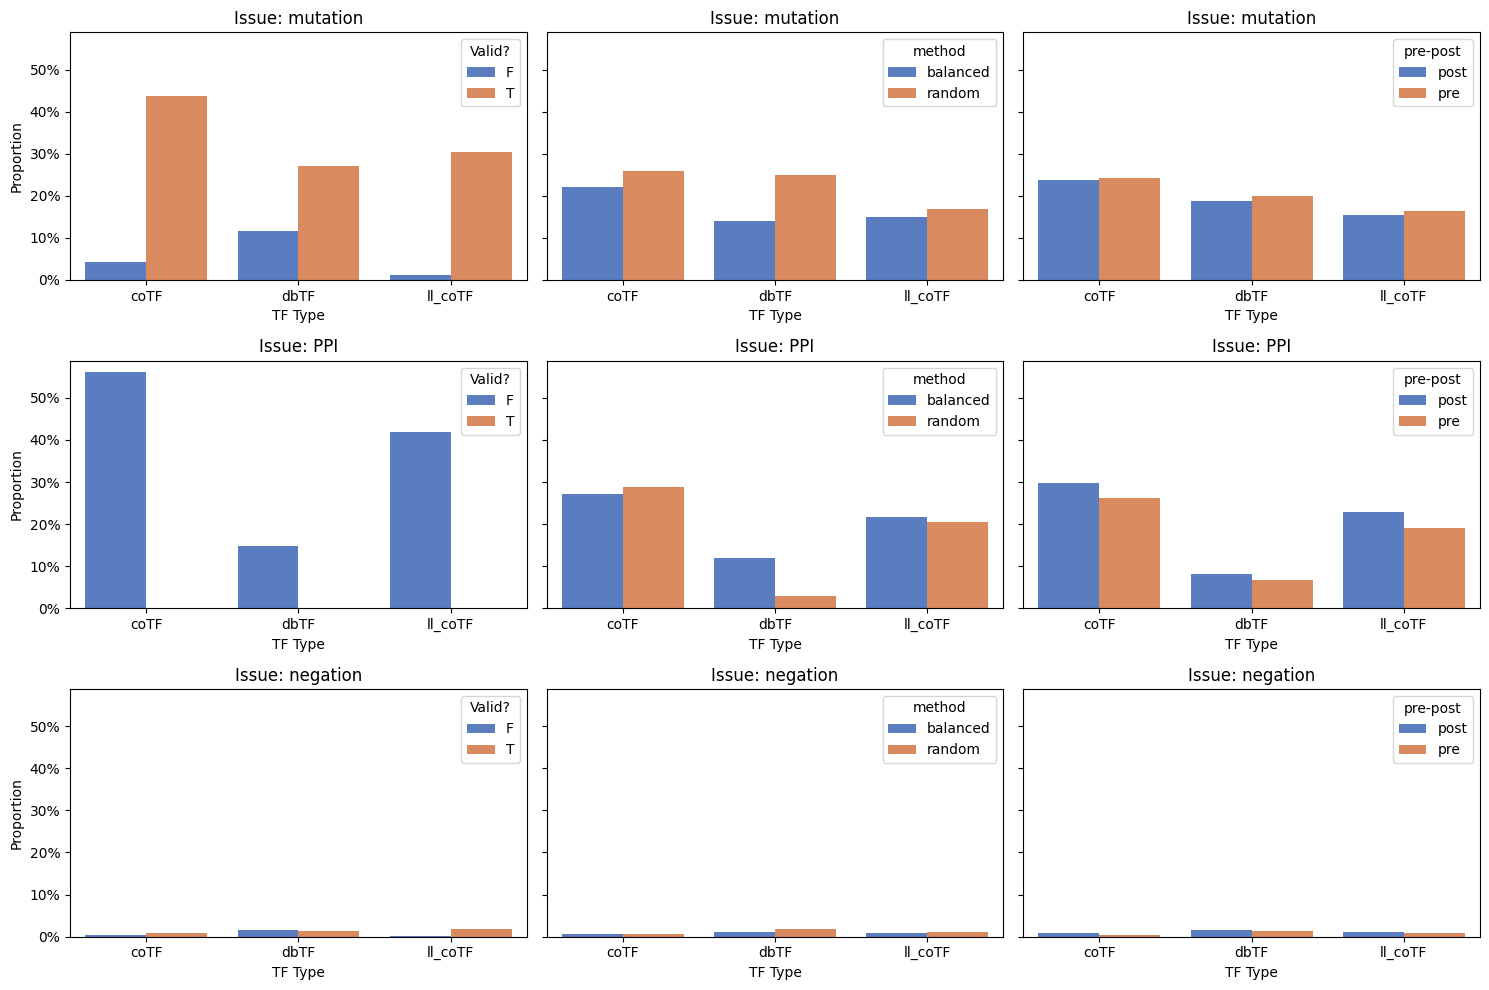

In [8]:
def evaluate_other_issues(validated_df):
    h3("Other issues")

    # Get sentences where there are other issues
    o_i = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first').dropna(subset=['Other issues'])

    # Display common issues
    display(o_i['Other issues'].apply(lambda x: x.split(';')).explode().value_counts())

    # Get uniquely validated sentences
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    # Splitter
    print(f"{validated_unique['Other issues'].str.contains('Splitter').sum()}/{len(validated_unique)} sentences are incorrecty splitted")
    print(f"{validated_unique['Other issues'].str.contains('suboptimal').sum()}/{len(validated_unique)} sentences are suboptimal")

    # Check for more common issues, and in what TF-types do they appear

    results = []
    for tf_type in ['dbTF', 'coTF', 'll_coTF']:

        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                for validity in ['T', 'F']:

                    df = validated_df[(validated_df['TF_type_validated'] == tf_type) & (validated_df['method'] == method) & (validated_df['pre-post'] == p) & (validated_df['Label'] == 'TRUE') & (validated_df['Valid?'] == validity)]
                    
                    r = {
                        'tf_type': tf_type,
                        'Valid?': validity,
                        'method': method,
                        'pre-post': p,
                        'num_sents': str(len(df))
                    }

                    for issue in ['mutation', 'PPI', 'negation']:
                        m = df['Other issues'].fillna('').str.contains(issue)
                        r[issue] = len(df[m]) / len(df) if m.sum() > 0 else 0
            
                    results.append(r)
    
    index_cols = ['tf_type', 'Valid?', 'method', 'pre-post']
    return pd.DataFrame(results).sort_values(by=index_cols).set_index(index_cols)
        

def plot_other_issues(o_i_results):
    # Reset the index to use the index columns as regular columns
    o_i_results_reset = o_i_results.reset_index()

    # Create a single figure with subplots for each issue
    issues = ['mutation', 'PPI', 'negation']
    hues = ['Valid?', 'method', 'pre-post']

    fig, axes = plt.subplots(nrows=len(issues), ncols=len(hues), figsize=(15, 10), sharey=True)

    for j, issue in enumerate(issues):
        for i, hue in enumerate(hues):
            ax = axes[j][i]
            sns.barplot(
                data=o_i_results_reset,
                x='tf_type', y=issue, hue=hue,
                ax=ax, palette='muted', errorbar=None
            )
            ax.set_title(f"Issue: {issue}")
            ax.set_xlabel('TF Type')
            ax.set_ylabel('Proportion' if i == 0 else '')
            ax.legend(title=hue, loc='upper right')

            ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Adjust layout
    plt.tight_layout()
    plt.show()

o_i_results = evaluate_other_issues(validated_df)
display(o_i_results)

# display(o_i_results)
plot_other_issues(o_i_results)

In [11]:
# RESULTS
def TRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include TRUE labels'''

    # Only consider TRUE labels
    validated_df = validated_df[validated_df['Label'] == 'TRUE']

    results = []
    for tf_type in ['dbTF', 'coTF', 'll_coTF']:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                df = validated_df[(validated_df['TF_type_validated'] == tf_type) & (validated_df['method'] == method) & (validated_df['pre-post'] == p)]
                
                r = {
                    'tf_type': tf_type,
                    'method': method,
                    'pre-post': p,
                    'num_sents': len(df)
                }

                # Get TRI stats
                r['Classifiers'] = (df['Valid?'] == 'T').sum() / r['num_sents']
                r['TRI'] = 1 - (df['Label'] != df['true_label']).sum() / r['num_sents']

                # Get MoR stats
                # r['num_TRI'] = (df['Label'] == 'TRUE').sum()
                r['MoR'] = 1 - len(df[(df['MoR'] != df['true_MoR']) & ~df['MoR'].isna()]) / r['num_sents']
                for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                    r[MoR] = 1 - len(df[(df['MoR'] == MoR) & (df['MoR'] != df['true_MoR'])]) / r['num_sents']

                # TODO - I tried that and it doesn't change the results much. Erase
                # num_TRI = (df['true_label'] == 'TRUE').sum()
                # r['MoR'] = 1 - len(df[(df['MoR'] != df['true_MoR']) & ~df['MoR'].isna()]) / num_TRI
                # for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                #     r[MoR] = 1 - len(df[(df['MoR'] == MoR) & (df['MoR'] != df['true_MoR'])]) / num_TRI


                # Get NER & norm stats
                r['norm'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('norm')).sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['NER'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('NER')).sum() for T in ['TF', 'TG'])) / r['num_sents']

                # Get final probaility
                r['total'] = r['Classifiers'] + r['norm'] + r['NER'] - 2

                # Ensure num_sents is not treated as a float in the printed table
                r['num_sents'] = str(r['num_sents'])
                results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type', 'method', 'pre-post']).T

def nonTRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include TRUE labels'''

    # Only consider TRUE labels
    # validated_df = validated_df[validated_df['Label'] == 'FALSE']
    validated_df = validated_df[(validated_df['method'] == 'random') & (validated_df['pre-post'] == 'post')]

    results = []
    for tf_type in ['dbTF', 'coTF', 'll_coTF']:
        df = validated_df[(validated_df['TF_type_validated'] == tf_type)]
        
        r = {'tf_type': tf_type}

        for label, state in (['TRUE', 'TRI'], ['FALSE', 'not TRI']):
            total_num = len(df[df['Label'] == label])
            num_valid = len(df[(df['Label'] == label) & (df['Label'] == df['true_label'])])

            r[state] = f"{num_valid}/{total_num} ({num_valid / total_num:.2%})"

        results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type']).T

def show_general_statistics(validated_df):
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    r = {}
    r['Total'] = len(validated_unique['#SentenceID'].unique())
    for TF in ['dbTF', 'coTF', 'll_coTF']:
        r[TF] = len(validated_unique[validated_unique['TF_type_validated'] == TF])
    
    display(pd.DataFrame.from_dict(r, orient='index', columns=['Number of sentences']))

    return

show_general_statistics(validated_df)

pd.set_option("display.float_format", "{:.1%}".format)

for results_table_f in (TRI_validation_results_table, nonTRI_validation_results_table):
    results_table = results_table_f(validated_df)
    h3(results_table_f.__name__)
    display(results_table)
    results_table.to_csv(f'tables/{results_table_f.__name__}.tsv', sep='\t')

,Number of sentences
Total,3981
dbTF,2067
coTF,1173
ll_coTF,741


<h3>TRI_validation_results_table</h3>

tf_type       dbTF                        coTF                      ll_coTF  \
method      random       balanced       random       balanced        random   
pre-post       pre  post      pre  post    pre  post      pre  post     pre   
num_sents      906   887      869   859    508   462      444   429     435   
Classifiers  84.3% 85.6%    81.1% 84.4%  61.6% 65.6%    57.9% 64.6%   54.5%   
TRI          92.1% 93.1%    84.2% 87.1%  63.8% 68.0%    60.1% 66.9%   56.3%   
MoR          91.6% 91.8%    96.9% 97.0%  97.6% 97.4%    97.7% 97.7%   98.2%   
ACTIVATION   96.5% 96.5%    99.1% 99.3%  99.0% 98.9%    98.4% 98.6%   99.1%   
REPRESSION   96.7% 96.8%    98.0% 98.0%  98.8% 98.7%    99.8% 99.5%   99.1%   
UNDEFINED    98.5% 98.4%    99.8% 99.7%  99.8% 99.8%    99.5% 99.5%  100.0%   
norm         95.0% 96.1%    94.8% 96.2%  96.3% 97.0%    95.5% 96.0%   96.3%   
NER          98.3% 98.6%    97.6% 98.6%  97.8% 98.1%    97.5% 97.7%   97.7%   
total        77.7% 80.3%    73.5% 79.2%  55.7% 60.6%    50.9% 58.3%   48.5%   

tf_type                             
method             balanced         
pre-post      post      pre   post  
num_sents      396      270    285  
Classifiers  58.8%    55.6%  57.5%  
TRI          60.9%    56.7%  59.3%  
MoR          98.0%    98.9%  98.2%  
ACTIVATION   99.0%    99.6%  99.6%  
REPRESSION   99.0%    99.3%  98.6%  
UNDEFINED   100.0%   100.0% 100.0%  
norm         98.7%    94.8%  95.4%  
NER          99.7%    98.5%  97.9%  
total        57.3%    48.9%  50.9%

<h3>nonTRI_validation_results_table</h3>

tf_type,dbTF,coTF,ll_coTF
TRI,826/887 (93.12%),314/462 (67.97%),241/396 (60.86%)
not TRI,289/291 (99.31%),169/169 (100.00%),98/98 (100.00%)


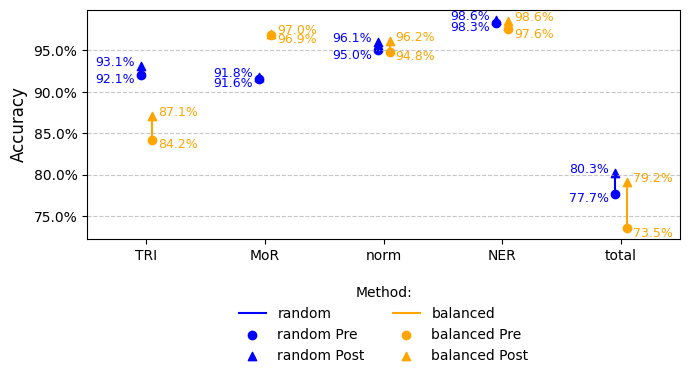

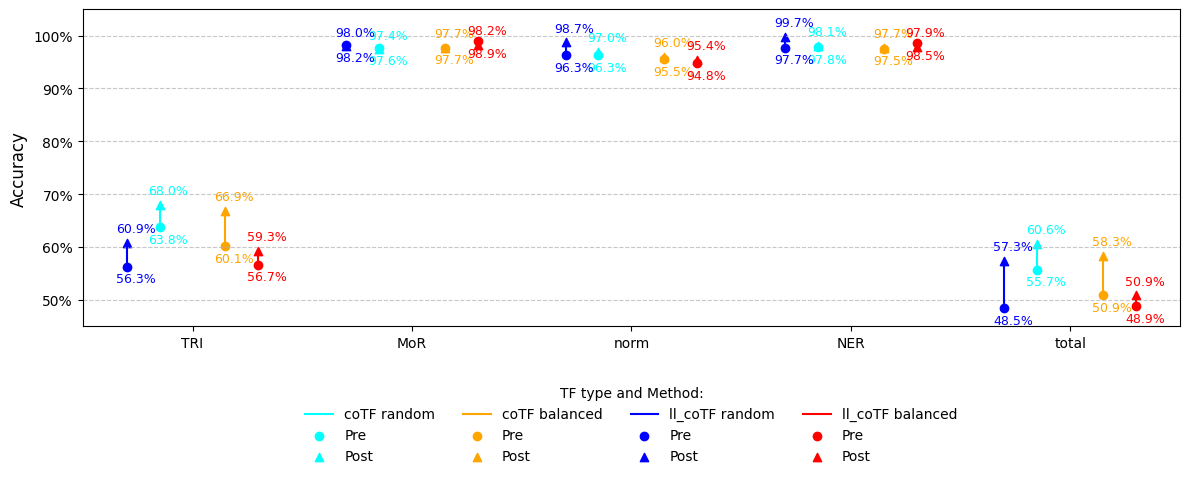

In [ ]:
def make_validation_dotplot(results_table, TF_type = 'dbTF', y_sep = 0):

    XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(7, 4))

    cols = ['TRI', 'MoR', 'norm', 'NER', 'total']
    for i, col in enumerate(cols):

        # Add vertical lines for random and balanced
        for method, sep, color, orientation in [('random', -0.05, 'blue', 'right'), ('balanced', 0.05, 'orange', 'left')]: 

            # Get values for random and balanced for pre and post
            values = {}
            for pre_post in ['pre', 'post']:
                values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['pre-post'] == pre_post)][col].values[0]

            ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=method if i == 0 else "")
            ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'{method} Pre' if i == 0 else "")
            ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'{method} Post' if i == 0 else "")

            # Add value labels next to the dots
            ax.text(i + sep*2, values['pre']-0.01-y_sep, f"{values['pre']:.1%}", fontsize=9, color=color, ha=orientation)
            ax.text(i + sep*2, values['post']+y_sep, f"{values['post']:.1%}", fontsize=9, color=color, ha=orientation)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    # ax.set_ylim(0.7, 1.0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def make_coTF_validation_dotplot(results_table, y_sep = 0.03):

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(12, 5))

    cols = ['TRI', 'MoR', 'norm', 'NER', 'total']

    for TF_type, x_sep in [('coTF', 0.15), ('ll_coTF', 0.3)]:

        XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

        for i, col in enumerate(cols):

            # Add vertical lines for random and balanced
            for method, sep, orientation in [('random', -x_sep, 'right'), ('balanced', x_sep, 'left')]: 

                if TF_type == 'coTF':
                    color = 'aqua' if method == 'random' else 'orange'
                else:
                    color = 'blue' if method == 'random' else 'red'

                # Get values for random and balanced for pre and post
                values = {}
                for pre_post in ['pre', 'post']:
                    values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['pre-post'] == pre_post)][col].values[0]

                ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=f"{TF_type} {method}" if i == 0 else "")
                ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'Pre' if i == 0 else "")
                ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'Post' if i == 0 else "")

                # Add value labels next to the dots
                ax.text(i + sep-0.05, values['pre']  - y_sep, f"{values['pre']:.1%}", fontsize=9, color=color)
                ax.text(i + sep-0.05, values['post'] + y_sep-0.01, f"{values['post']:.1%}", fontsize=9, color=color)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    ax.set_ylim(0.45, 1.05)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='TF type and Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


TRI_results_table = TRI_validation_results_table(validated_df).T.reset_index()
make_validation_dotplot(TRI_results_table)
make_coTF_validation_dotplot(TRI_results_table)

# make_validation_dotplot(results_table, 'coTF', y_sep=0.01)
# make_validation_dotplot(results_table, 'll_coTF', y_sep=0.01)

COMMENT:
* MoR remains largely unaffected by whether it is pre, post, random or not random. It is constant.
* TRI, however, is more affected. Specially for dbTF, we see a drop of 10% in the accuracy of the model when calculating balanced datasets. A trend that is not observable in coTF. This shows that our model has been trained to somewhat learn the most popular TFs
* However, for coTF it doesn't change much, as it hasn't been trained on coTFs, proving even more that it has learned about the dbTFs to consider as positives. The model is therefore better at recalling more popular TFs than those that it hasn't seen on the training set.
* For the balanced, there is a big leap between pre- and post-, which I should try to find a way to understand
* NER and norm do not see much change between conditions: they're good independently of the frequency

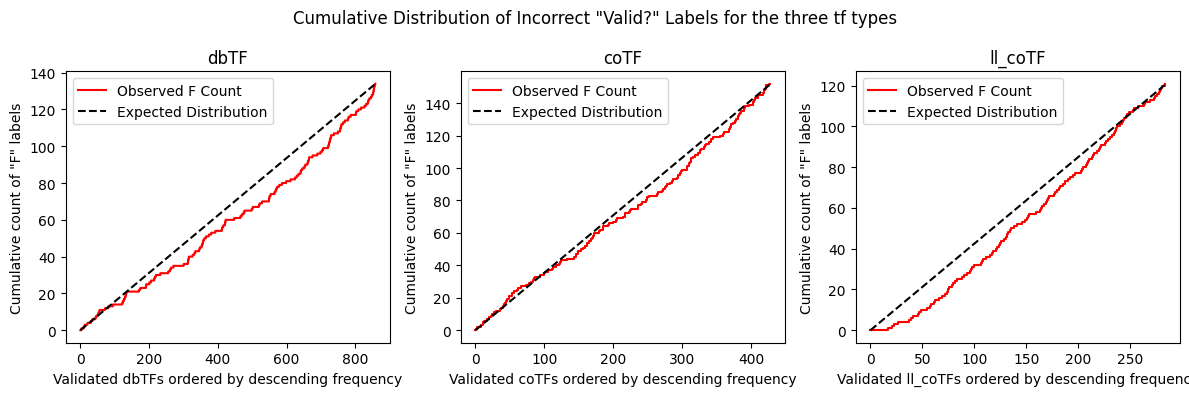

In [36]:
def plot_false_validation_distribution(ExTRI2_df: pd.DataFrame, val_df: pd.DataFrame):

    # Initialise plot
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    plt.suptitle('Cumulative Distribution of Incorrect "Valid?" Labels for the three tf types')


    for i, tf_type in enumerate(['dbTF', 'coTF', 'll_coTF']):

        # Get the subset of all sentences
        all_sents = ExTRI2_df[ExTRI2_df['TF_type'] == tf_type]

        # Get the subset of balanced TF_type sentences (post-processing)
        val_balanced = val_df[(val_df['TF_type'] == tf_type) & (val_df['method'] == 'balanced') & (val_df['pre-post'] == 'post')].copy()

        # Count frequency of TF Ids in all_sents
        tf_frequencies = all_sents['TF Id'].value_counts()

        # Order the val_balanced dataset by TF frequency
        val_balanced['TF_frequency'] = val_balanced['TF Id'].map(tf_frequencies)
        val_balanced = val_balanced.sort_values(by='TF_frequency', ascending=False)

        # Add a column for the 'F' binary values (1 if Valid?=F, otherwise 0)
        val_balanced['Is_F'] = (val_balanced['Valid?'] == 'F').astype(int)

        # Compute cumulative sum of 'Is_F' for plotting
        val_balanced['Cumulative_F'] = val_balanced['Is_F'].cumsum()

        # Step 5: Plot the cumulative sum of 'F's
        ax = axes[i]
        ax.step(range(len(val_balanced)), val_balanced['Cumulative_F'], where='mid', label='Observed F Count', color='red')
        
        # Step 6: Plot the expected line
        total_f_count = val_balanced['Is_F'].sum()
        ax.plot(range(len(val_balanced)), [total_f_count * (i / len(val_balanced)) for i in range(len(val_balanced))], label='Expected Distribution', linestyle='--', color='black')
        
        # Customize plot
        ax.set_title(tf_type)
        ax.set_xlabel(f'Validated {tf_type}s ordered by descending frequency')
        ax.set_ylabel('Cumulative count of "F" labels')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_false_validation_distribution(ExTRI2_df, validated_df)

What is seen here is that unvalid sentences are more concentrated towards the end, but not by much. However, this is observed in dbTF, coTF and ll_coTF, while we might have expected dbTF to be the one that shows it more pronunciately

### MUST CORRECT

In [14]:
# TODO - Validation dataset is not complete. Sort out all the TODOs here & move it to validation.ipynb
print(len(validated_df[validated_df['pre-post'] == 'pre']['Sentence'].unique()))

3074


In [15]:
# DIFFERENT TODOs
# TODO - Astrid considered "Negation" as positive. I should change this in validation. (haven't I already? Check)

# TODO - the "dir-syntax" and "dir-?" are not analysed at all. Should I?
# TODO - If I show Astrid, put it in a more appropriate folder
# TODO - Check if 'Negation' is considered as positive or negative
m = validated_df['Other issues'].str.contains('negation')


# TODO - Talk with Astrid on what to do with those sentences
# TODO - Add also the ones obtained from the iterations on the NTNU dataset. 
#        & save them somewhere
# Number of PPI sentences: 
validated_df['Other issues'].fillna('', inplace=True)
m = validated_df['Other issues'].str.contains('PPI')
validated_df[m]['TF_type_validated'].value_counts()

TF_type_validated
coTF       386
ll_coTF    250
dbTF        86
Name: count, dtype: int64

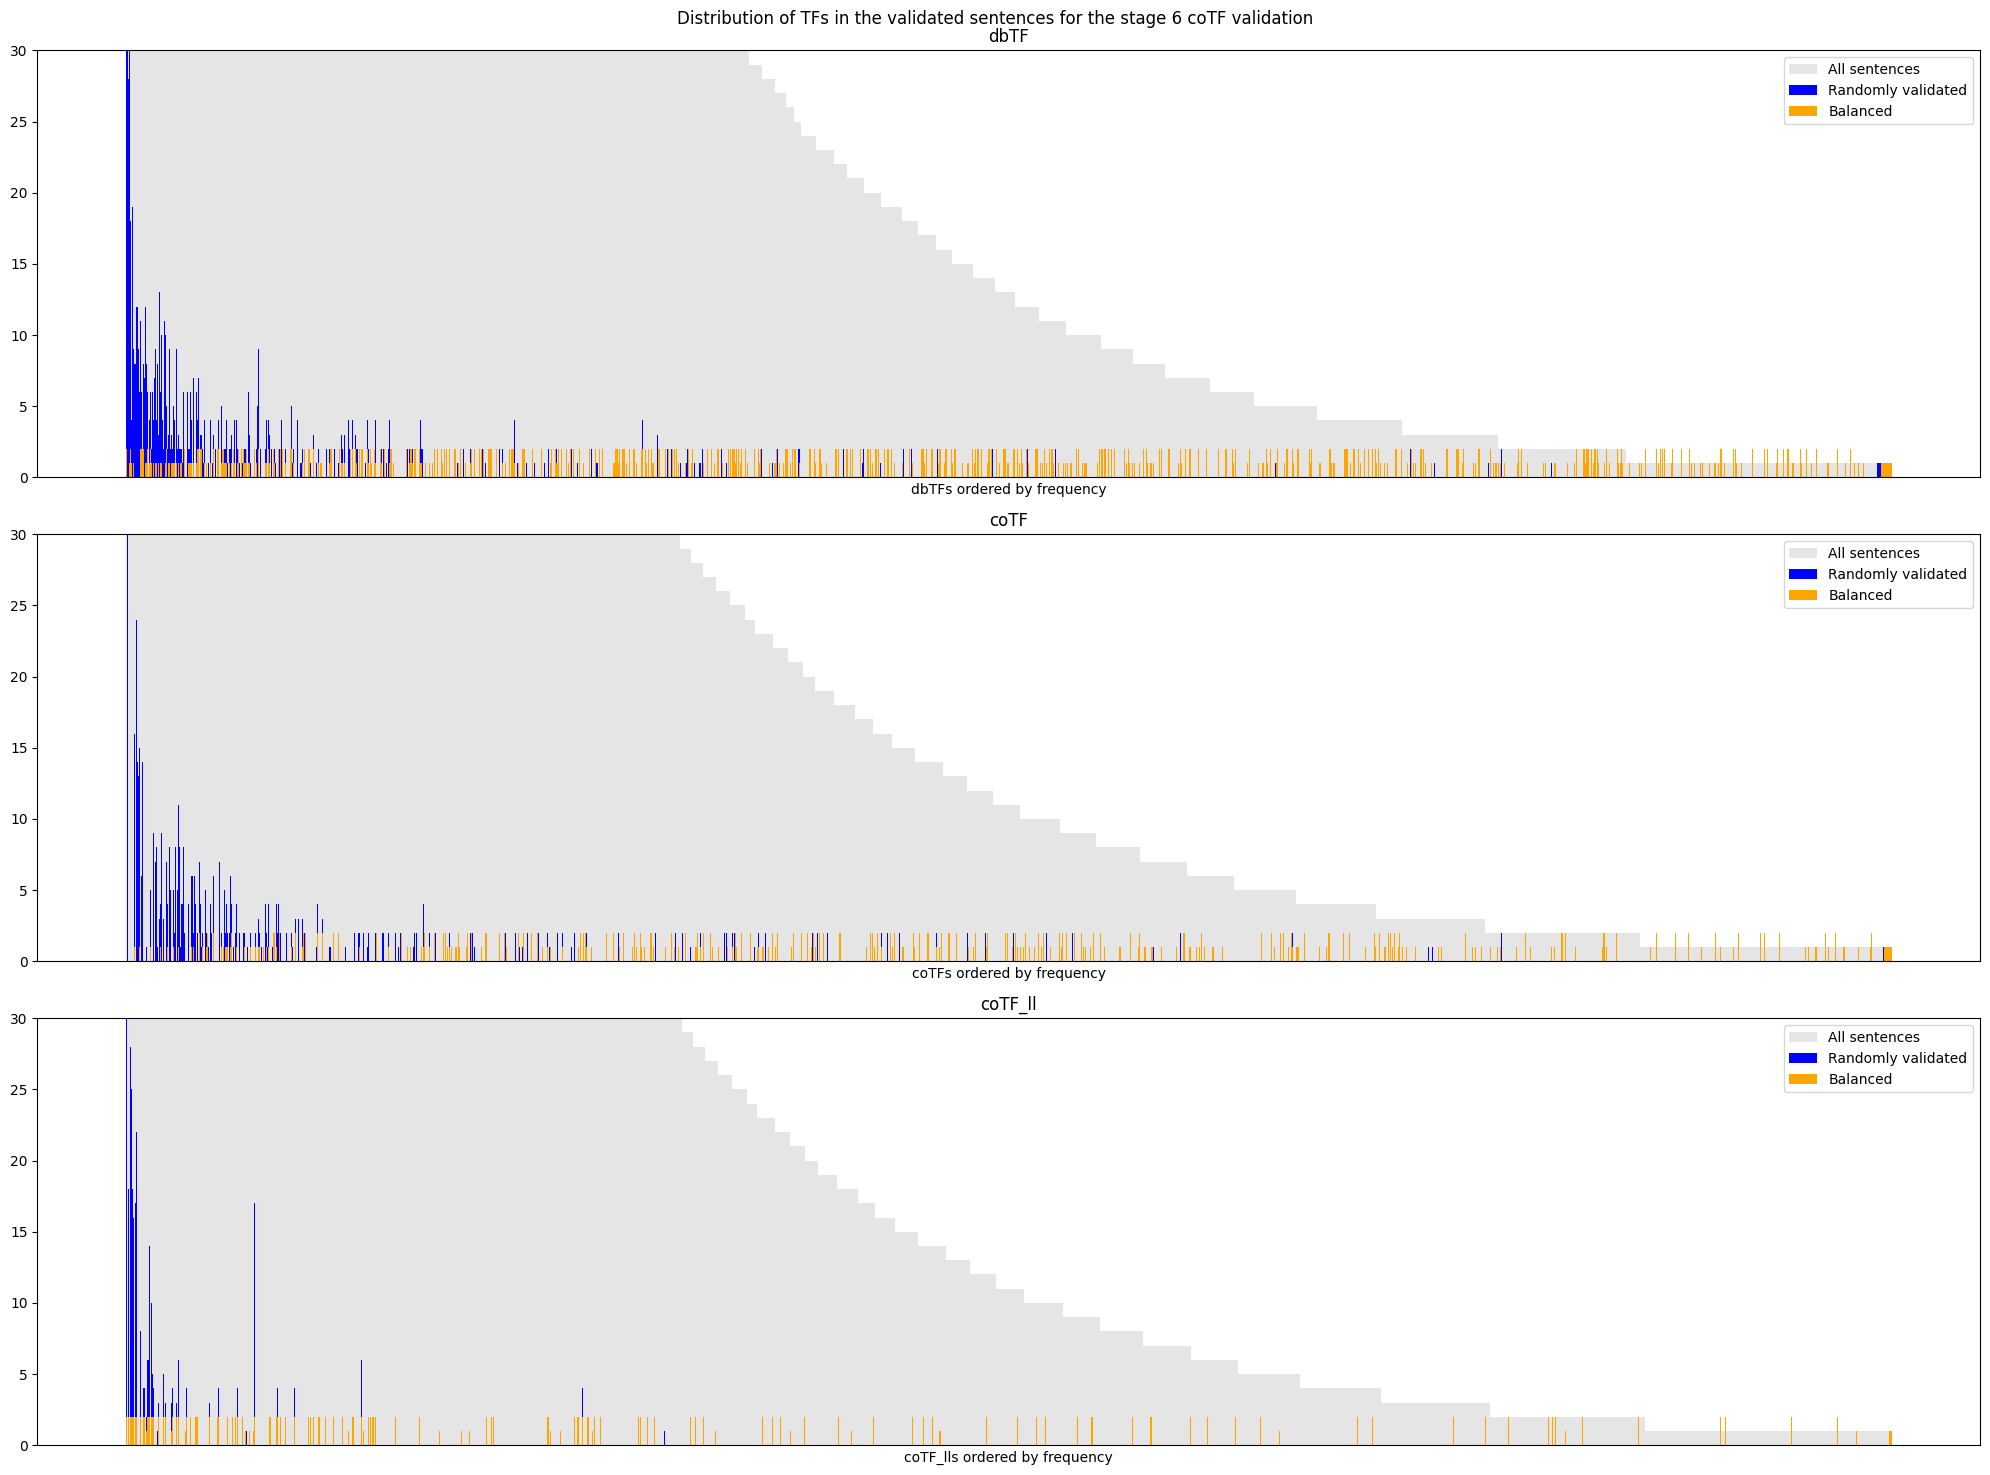

In [16]:
# TODO - Remove this plot maybe? It includes those mapped to +1 TFs
# Get TRI & validated datasets
TRI_dbTF = ExTRI2_df[ExTRI2_df['TF_type'].str.contains('dbTF')]
TRI_coTF = ExTRI2_df[(ExTRI2_df['TF_type'].str.contains('coTF')) & (~ExTRI2_df['TF_type'].str.contains('dbTF'))]


dbTF_val_b = validated_df[(validated_df['TF_type'] == 'dbTF') & (validated_df['method'] == 'balanced')]
dbTF_val_r = validated_df[(validated_df['TF_type'] == 'dbTF') & (validated_df['method'] == 'random')]
coTF_val_b = validated_df[(validated_df['TF_type'] == 'coTF') & (validated_df['method'] == 'balanced')]
coTF_val_r = validated_df[(validated_df['TF_type'] == 'coTF') & (validated_df['method'] == 'random')]
coTF_ll_val_b = validated_df[(validated_df['TF_type'] == 'll_coTF') & (validated_df['method'] == 'balanced')]
coTF_ll_val_r = validated_df[(validated_df['TF_type'] == 'll_coTF') & (validated_df['method'] == 'random')]


# Plot
fig, axes = plt.subplots(3, 1, figsize=(20, 15))
plot_tf_validation_distribution(axes[0], 'dbTF', TRI_dbTF, val_balanced = dbTF_val_b, val_random = dbTF_val_r)
plot_tf_validation_distribution(axes[1], 'coTF', TRI_coTF, val_balanced = coTF_val_b, val_random = coTF_val_r)
# TODO - This is incorrect as it doesn't include the ll_coTF TRI correctly
plot_tf_validation_distribution(axes[2], 'coTF_ll', TRI_coTF, val_balanced = coTF_ll_val_b, val_random = coTF_ll_val_r)

plt.suptitle("Distribution of TFs in the validated sentences for the stage 6 coTF validation")
plt.tight_layout()
plt.show()

In [17]:
# Analytics
def display_dict(analysis_dict: dict, columns=["Correct", "Total"]):
    """
    Input format: dict(list[:2]) where list[0] is a subset of list[1].
    Displays the dict and the percentage between list[0]/list[1]
    TODO - Is this a correct docstring? Improve w/ChatGPT
    """
    df = pd.DataFrame.from_dict(analysis_dict, orient="index", columns=columns)
    df['perc'] = df['Correct'] / df['Total'] * 100
    display(df)

labels = ["dbTF random", "dbTF balanced", "coTF random", "coTF balanced", "coTF ll random", "coTF ll balanced"]
dfs    = [dbTF_val_r, dbTF_val_b, coTF_val_r, coTF_val_b, coTF_ll_val_r, coTF_ll_val_b]

h3("TRI + MoR")
display_dict({label: [(df['Valid?'] == 'T').sum(), len(df)] for label, df in zip(labels, dfs)})

h3("TRI")
display_dict({label: [(~((df['Valid?'] == 'F') & (df['true_label'] != df['Label']))).sum(), 
                      len(df)] for label, df in zip(labels, dfs)})

h3("MoR")
def get_correct_total_MoR(df):
    total = (~((df['Valid?'] == 'F') & (df['true_label'] != df['Label']))).sum()
    incorrect = ((df['Valid?'] == 'F') & (df['true_label'] == df['Label']) & (df['Label'] == "TRUE")).sum()
    return (total - incorrect, total)
display_dict({label: get_correct_total_MoR(df) for label, df in zip(labels, dfs)})

h3("Norm/NER")
display_dict({label: [(df['TF_is_incorrect'].isna() & df['TF_is_incorrect'].isna()).sum(), len(df)] for label, df in zip(labels, dfs)})
# TODO - I don't believe the Norm/NER results. Check if that's biased due to NFKB still marked as unvalid

md("Isues in all sentences")
display(validated_df['Other issues'].value_counts())
print(len(validated_df))

md("Issues in unvalid sentences")
display(validated_df[validated_df['Valid?'] == 'F']['Other issues'].value_counts())
print(len(validated_df[validated_df['Valid?'] == 'F']))

md("Issues in unvalid dbTFsentences")
display(validated_df[(validated_df['Valid?'] == 'F') & (validated_df['TF_type'] == 'dbTF')]['Other issues'].value_counts())
print("Num invalid: ", len(validated_df[(validated_df['Valid?'] == 'F') & (validated_df['TF_type'] == 'dbTF')]))
print("Num dbTF: ", len(validated_df[(validated_df['TF_type'] == 'dbTF')]))


<h3>TRI + MoR</h3>

,Correct,Total,perc
dbTF random,1812,2084,8694.8%
dbTF balanced,1430,1728,8275.5%
coTF random,785,1139,6892.0%
coTF balanced,534,873,6116.8%
coTF ll random,568,929,6114.1%
coTF ll balanced,314,555,5657.7%


<h3>TRI</h3>

,Correct,Total,perc
dbTF random,1961,2084,9409.8%
dbTF balanced,1483,1728,8582.2%
coTF random,809,1139,7102.7%
coTF balanced,554,873,6345.9%
coTF ll random,584,929,6286.3%
coTF ll balanced,322,555,5801.8%


<h3>MoR</h3>

,Correct,Total,perc
dbTF random,1812,1961,9240.2%
dbTF balanced,1430,1483,9642.6%
coTF random,785,809,9703.3%
coTF balanced,534,554,9639.0%
coTF ll random,568,584,9726.0%
coTF ll balanced,314,322,9751.6%


<h3>Norm/NER</h3>

,Correct,Total,perc
dbTF random,2053,2084,9851.2%
dbTF balanced,1677,1728,9704.9%
coTF random,1119,1139,9824.4%
coTF balanced,839,873,9610.5%
coTF ll random,912,929,9817.0%
coTF ll balanced,537,555,9675.7%


Isues in all sentences

Other issues
                     4812
mutation             1609
PPI                   715
Splitter               74
negation               38
mutation;negation      34
Splitter;mutation      10
suboptimal              9
PPI;Splitter            3
PPI;suboptimal          2
PPI;negation            2
Name: count, dtype: int64

7308


Issues in unvalid sentences

Other issues
                     994
PPI                  715
mutation              97
Splitter              32
suboptimal             9
mutation;negation      6
negation               5
PPI;Splitter           3
PPI;suboptimal         2
PPI;negation           2
Name: count, dtype: int64

1865


Issues in unvalid dbTFsentences

Other issues
                     385
PPI                   85
mutation              59
Splitter              22
suboptimal             9
mutation;negation      6
negation               3
PPI;Splitter           1
Name: count, dtype: int64

Num invalid:  570
Num dbTF:  3812
